1. Set up the environment

In [1]:
# Check python and CUDA version
!python --version
!nvcc --version

Python 3.6.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148


In [0]:
# Map your google drive 
from google.colab import drive
drive.mount('/content/drive/')
!ls "drive/My Drive"

In [12]:
!ls "drive/My Drive/app"

car.jpeg  hymenoptera_data	     mnist_cnn.py  test.ipynb
cat.png   imagenet_class_index.json  ResNet.ipynb


In [4]:
!pip install pillow==4.1.1

    100% |████████████████████████████████| 5.7MB 7.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [6]:
# Install Pytorch
!pip install torch torchvision

    100% |████████████████████████████████| 519.5MB 34kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59f14000 @  0x7fd208c882a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 23.5MB/s 


In [7]:
# Check the pytorch version
import torch, torchvision
from torch import nn,optim
from torch.autograd import Variable as var 

print(torch.__version__)
!pip show torch

0.4.1
Name: torch
Version: 0.4.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: UNKNOWN
Author: UNKNOWN
Author-email: UNKNOWN
License: UNKNOWN
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: torchvision


2. Design your own simple CNN

In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable


'''
First CNN example from scract using the MNIST dataset
'''


train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset  = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

print(train_dataset.train_data.size())
#print(train_dataset.train_labels[1:10])
print(len(train_dataset))

print("Tensor size of test: "+str(test_dataset.test_data.size()))


batch_size = 100
n_iters = 3000
num_epochs = n_iters/ (len(train_dataset)/batch_size)
num_epochs = int(num_epochs)
print("Number of epochs: "+ str(num_epochs))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle = False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=5,stride=1,padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(in_features=32*7*7,out_features=10)

    def forward(self,x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)

        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        # resize (flat) to be compatible with following fully connected layer
        out = out.view(out.size(0),-1)

        out = self.fc1(out)

        return out

model = CNNModel()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),learning_rate)

for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

iter = 0
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs,labels)

        loss.backward()
        optimizer.step()

        iter += 1
        if iter % 500==0:
            correct = 0
            total = 0

            for images,labels in test_loader:
                images = Variable(images)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter,loss.data[0],accuracy))


3. Use pre-trained model for classification

torchvision.models provides a number of pre-trained popular models including AlexNet, VGG, ResNet, SqueezeNet, DenseNet, and Inception v3. Have a look here: 
https://pytorch.org/docs/stable/torchvision/models.html

These can be constructed by passing pretrained=True:

In [8]:
# Download ResNet18 pre-trained network
from torchvision import models
model_ft = models.resnet18(pretrained=True)

# Visualize the ResNet18 architecture
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 21215999.43it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


['sports_car: 0.29007685', 'minivan: 0.25378454', 'car_wheel: 0.23556219', 'convertible: 0.075849816', 'beach_wagon: 0.0733306', 'grille: 0.04887234', 'pickup: 0.0074483226', 'racer: 0.0060157445', 'limousine: 0.0031727876', 'cab: 0.001457608']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


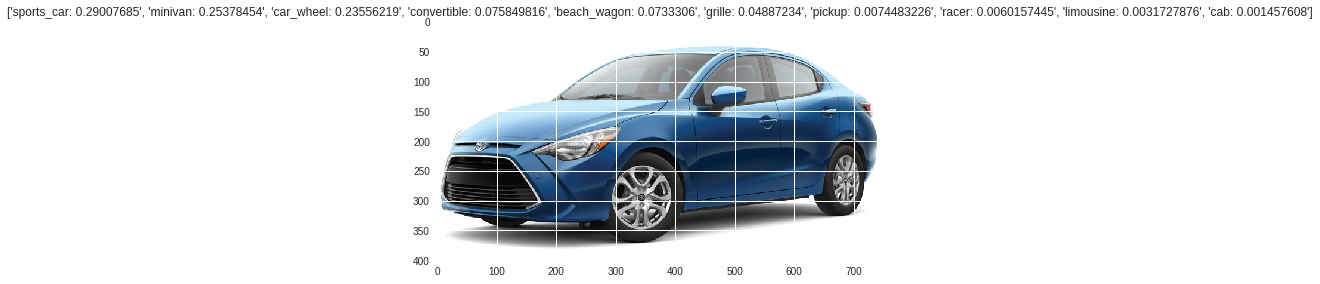

In [9]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json, string



# 1. Define the appropriate image pre-processing function.
preprocessFn = transforms.Compose([transforms.Scale(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in json.load(open('drive/My Drive/app/imagenet_class_index.json')).items()}

# 3. Forward a test image of the toaster.
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
model_ft.eval()
# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('drive/My Drive/app/car.jpeg').convert('RGB')
inputVar =  Variable(preprocessFn(image).unsqueeze(0))

predictions = model_ft(inputVar)

# 4. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-nn.Softmax()(predictions).data).sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

print(preds)
# 5. Show image and predictions
plt.title(preds)
plt.imshow(image)


3. Design your own ResNet

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

Train and test on CIFAR dataset

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = ResNet18()
print(net)

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print('Test loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc


for epoch in range(start_epoch, start_epoch+200):
    train(epoch)
    test(epoch)

==> Preparing data..
Files already downloaded and verified
==> Building model..
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

Process Process-10:
Process Process-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/usr/lib/python3.

KeyboardInterrupt: ignored

KeyboardInterrupt
KeyboardInterrupt


4. Transfer learning with ResNet

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


torch.Size([4, 3, 224, 224]) tensor([1, 0, 0, 0])
Epoch 0/24
----------
LR is set to 0.001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Loss: 0.1283 Acc: 0.0000
val Loss: 0.0393 Acc: 0.0000

Epoch 1/24
----------
train Loss: 0.1514 Acc: 0.0000
val Loss: 0.0686 Acc: 0.0000

Epoch 2/24
----------
train Loss: 0.1404 Acc: 0.0000
val Loss: 0.0605 Acc: 0.0000

Epoch 3/24
----------
train Loss: 0.2241 Acc: 0.0000
val Loss: 0.0975 Acc: 0.0000

Epoch 4/24
----------
train Loss: 0.0910 Acc: 0.0000
val Loss: 0.1214 Acc: 0.0000

Epoch 5/24
----------
train Loss: 0.1291 Acc: 0.0000
val Loss: 0.1780 Acc: 0.0000

Epoch 6/24
----------
train Loss: 0.1120 Acc: 0.0000
val Loss: 0.1117 Acc: 0.0000

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0723 Acc: 0.0000
val Loss: 0.2329 Acc: 0.0000

Epoch 8/24
----------
train Loss: 0.0859 Acc: 0.0000
val Loss: 0.2739 Acc: 0.0000

Epoch 9/24
----------
train Loss: 0.0710 Acc: 0.0000
val Loss: 0.2215 Acc: 0.0000

Epoch 10/24
----------
train Loss: 0.0673 Acc: 0.0000
val Loss: 0.1851 Acc: 0.0000

Epoch 11/24
----------
train Loss: 0.0668 Acc: 0.0000
val Loss: 0.1664 Acc: 0.0000

Epoc

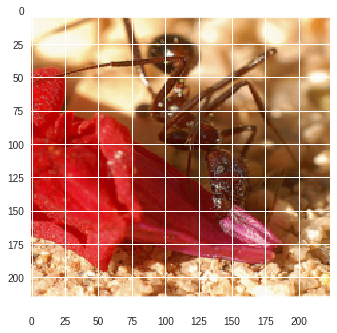

In [20]:
'''
Use pre-trained ResNet as an initialization
Train the whole network with this initialization
'''


import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

#plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/My Drive/app/hymenoptera_data'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(10)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

print(inputs.shape, classes)


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[dset_classes[x] for x in classes])



def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

In [13]:
!ls "drive/My Drive/app"

car.jpeg  hymenoptera_data	     mnist_cnn.py  test.ipynb
cat.png   imagenet_class_index.json  ResNet.ipynb
